# Data Cleaning Project 1

## Part III - Examine the difference of fruit pricing between different fruit types by year

Part III is an extension of part II. If all of the fruit have values for fresh, processed, and all variables, then this part could be ommitted. However, there's no fresh and processed data for melons and some fruit. Therefore, we will only acquire data for grower price on all fruits here and compare among fruits or or categories. 

The main variable:

* **All** : Grower price on all fruits

For part III of the project, we will: 

1. Read the documentation and familiarize yourself with the dataset. 
2. Combine all of the data files into one large dataset with meaningful value for 'All' variable. 
3. Change all values into the same unit per comparison.
4. Plot the trend of grower price on overall grower price by year for all fruits.
5. Plot the average grower price by category.
6. Plot a 4 by 1 plots with 4 subplots for each category, with individual overall fruit prices and the average of each category. 
 


### Data Cleaning

In [206]:
# load necessary packages 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import glob
from itertools import cycle, islice

# change display format
#pd.options.display.float_format = '{:.3f}'.format

listOfFiles = glob.glob("data/Part II & III/*.xlsx")
listOfFiles

['data/Part II & III\\FruitYearbookBerries_DTables.xlsx',
 'data/Part II & III\\FruitYearbookCitrusFruit_CTables.xlsx',
 'data/Part II & III\\FruitYearbookMelons_ETables.xlsx',
 'data/Part II & III\\FruitYearbookNoncitrusFruit_BTables.xlsx']

The data contains 4 files with differet number of worksheets, so the issue that we need to deal with for cleaning the data is how to select the useful information from these files. 

In [15]:
# define helper functions

def capitalize(line):
    return ' '.join(s[0].upper() + s[1:] for s in line.split(' '))

def findFruitName(x, sheetName):
    if sheetName == 'tab-d3a':
        return 'Boysenberries' 
    elif sheetName == 'tab-d3b':
        return 'Loganberries'
    else: 
        firstIndex = x.index('--')
        secondIndex = x.index(':')
        result = x[firstIndex+2:secondIndex]
        result = result.replace('All ', '')
        result = result.replace('U.S. ', '')
        result = result.capitalize()
        return result

def findYear(x):
    try: 
        firstIndex = x.index('/') 
        return x[:firstIndex]
    except: 
        return x

#### Create a dictionary to deal with different worksheets in each file

In [207]:
# create a dictionary to store the columns to pull for each worksheet in the files
listOfFiles = glob.glob("data/Part II & III/*.xlsx")
listOfFiles

berriesList = list(range(1,10)) 
citrusList = [4, 15, 22]
melonList = [11,12,13] ###
noncitrusList1 = [4, 8, 11, 14, 23, 24, 27, 33] ###
noncitrusList2 = [9, 10, 18, 19] ###


all_sheets = {}
for f in listOfFiles: 
    xls_file = pd.ExcelFile(f)
    sheet_names = xls_file.sheet_names
    
    if f == listOfFiles[0]:
        for i in range(len(sheet_names)): 
            if i in berriesList: 
                all_sheets[sheet_names[i]] = [0,10]
            elif i == 11:
                all_sheets[sheet_names[i]] = [0,13]
            elif i == 12: 
                all_sheets[sheet_names[i]] = [0,3]
                
    elif f == listOfFiles[1]: 
        for i in range(len(sheet_names)): 
            if i in citrusList: 
                df= xls_file.parse(sheet_names[i],header = 0)  
                length = len(df.columns)          
                all_sheets[sheet_names[i]] = [0, length-1]
                
    elif f == listOfFiles[2]:
        for i in range(len(sheet_names)): 
            if i in melonList: 
                all_sheets[sheet_names[i]] = [0,15]
                
    else: 
        for i in range(len(sheet_names)): 
            if i in noncitrusList1: 
                all_sheets[sheet_names[i]] =[0, 9]
            elif i == 20: 
                df= xls_file.parse(sheet_names[i],header = 0)  
                length = len(df.columns)          
                all_sheets[sheet_names[i]] = [0,length-1]     
            elif i in noncitrusList2:   
                df= xls_file.parse(sheet_names[i],header = 0)  
                length = len(df.columns)      
                all_sheets[sheet_names[i]] = [0, length-2]
print(all_sheets)

{'tab-d1': [0, 10], 'tab-d2a': [0, 10], 'tab-d2b': [0, 10], 'tab-d2c': [0, 10], 'tab-d2d': [0, 10], 'tab-d3a': [0, 10], 'tab-d3b': [0, 10], 'tab-d4': [0, 10], 'tab-d5': [0, 10], 'tab-d7': [0, 13], 'tab-d8': [0, 3], 'tabc4': [0, 19], 'tabc15': [0, 11], 'tabc22': [0, 19], 'Table E-11': [0, 15], 'Table E-12': [0, 15], 'Table E-13': [0, 15], 'tabb-4': [0, 9], 'tabb-8': [0, 9], 'tabb-9': [0, 10], 'tabb10': [0, 5], 'tabb11': [0, 9], 'tabb14': [0, 9], 'tabb18': [0, 9], 'tabb19': [0, 3], 'tabb20': [0, 7], 'tabb23': [0, 9], 'tabb24': [0, 9], 'tabb27': [0, 9], 'tabb33': [0, 9]}


We are using the overall price here, so any fruit without this variable will not be included here (such as pineapples). 

In [67]:
# only keep data with complete Fresh, Processed, and ALl data

combined_data = pd.DataFrame()
for f in listOfFiles: 
    fruitType = None
    xls_file = pd.ExcelFile(f)
    sheet_names = xls_file.sheet_names
    
    for i in (sheet_names): 
        new = pd.DataFrame()
        if i == 'Content':
            df= xls_file.parse(i,header = 0)
            fruitType = df.columns.values[0]
            
        elif i in all_sheets: 
            df= xls_file.parse(i,header = 0)  
            new = df[df.columns[all_sheets[i]]]
            new = new.dropna()
            new= new.reset_index()

            ## format of Melon files are different, 'tabc15' is lemons
            if i in ('tabc15', 'Table E-11', 'Table E-12', 'Table E-13', 'tab-d8', 'tabb-9', 'tabb10', 'tabb18', 'tabb19'): 
                new.columns = ['index', 'Year', 'All'] 
                new.Year = new.Year.apply(findYear)
                k = pd.DataFrame(new['All'])
                new = new[k.applymap(np.isreal).all(1)]    
            
            else: 
                new.columns = ['index', 'Year', 'All']
                tmp = new[['index', 'All']]
                new = new[tmp.applymap(np.isreal).all(1)]

            # set variables
            new['Category'] = fruitType
            new['Fruit'] = findFruitName(df.columns[0], i)
            new.Year = new.Year.apply(findYear)
            
            # rearrange columns
            new = new[['Category', 'Fruit', 'Year', 'All']]        
            
        else: 
            continue
        combined_data = combined_data.append(new, ignore_index=True) 

# rename some variables
combined_data.Fruit = combined_data.Fruit.replace('U.S. ', '', regex= True)
combined_data.Fruit = combined_data.Fruit.replace('All ', '', regex= True)
combined_data.Fruit = combined_data.Fruit.replace('Cherries, sweet', 'Cherries', regex= True)
combined_data.Category = combined_data.Category.replace(' Fruit', '', regex= True)

#change variable type
combined_data.ix[:, 'Year'] = combined_data.ix[:, 'Year'].astype(int)
combined_data.ix[:, 'All'] = combined_data.ix[:, 'All'].astype(float)

print(combined_data.head())
print()
print('Number of fruits in this dataset: ', len(combined_data.Fruit.unique()))
print('The combined data have ', combined_data.shape[0], ' rows')

  Category         Fruit  Year   All
0  Berries  Blackberries  1980  20.4
1  Berries  Blackberries  1981  17.5
2  Berries  Blackberries  1982  24.2
3  Berries  Blackberries  1983  29.3
4  Berries  Blackberries  1984  49.8

Number of fruits in this dataset:  27
The combined data have  1381  rows


#### Remove disparse data

Since only the melons contain data between 1970 to 1980, we will not include those data in this dataset. 

In [68]:
combined_data = combined_data[combined_data.Year >= 1980]

#### Aggregate price data across different states

Now we have a dataset with complete data for grower price for all fruits by years. However, most of the data in the berries category contain data from multiple states. For example, blueberries data contains data from 14 states. 

If we assume these states are representative for U.S., then we can take an average of these data and get an representative data for the U.S. Similarly for other berries, we have data from different number of states. We'll get an average for each fruit in the berries category. 

In [69]:
BerriesDf = pd.DataFrame()
fruitList = combined_data.Fruit[combined_data.Category == 'Berries'].unique()

combined_data['All'] =combined_data['All'].astype(float)

# combine diff states data for "berries" 
for i in fruitList:  
    tmp = combined_data[combined_data.Fruit == i]
    avgData = tmp.groupby(['Category', 'Fruit', 'Year'], sort = True)['All'].mean()
    avgData = avgData.reset_index()
    BerriesDf = BerriesDf.append(avgData, ignore_index=True)

# change decimal places
BerriesDf.All = round(BerriesDf.All,2) 

# edit fruit names
BerriesDf.Category = BerriesDf.Category.replace(' Fruit', '', regex= True)
print(BerriesDf.head())
print()
print('The new berries data have ', BerriesDf.shape[0], ' rows')

  Category         Fruit  Year   All
0  Berries  Blackberries  1980  20.4
1  Berries  Blackberries  1981  17.5
2  Berries  Blackberries  1982  24.2
3  Berries  Blackberries  1983  29.3
4  Berries  Blackberries  1984  49.8

The new berries data have  281  rows


Now we've calculated the averages for all berries categories, we will now combine it with the original data. 

In [70]:
combined_data = combined_data[combined_data.Category != 'Berries']
combined_data = combined_data.append(BerriesDf)

print(combined_data.shape)

(960, 4)


#### Convert all prices to the same unit (dollar/pound)

Since all fruit prices have different units, we have to change them to the same unit. We will use dollar/pound for the price unit. 

In [71]:
# create a dictionary for grouping fruits with the same unit
dicFruitUnit = {}

# cents/lb
for i in combined_data.Fruit.unique():
    # cents/lb for all three
    if i in ('Blackberries', 'Blueberries', 'Boysenberries', 'Loganberries', 'Black raspberries', 
             'Red raspberries', 'Bananas', 'Guavas', 'Papayas'):
        dicFruitUnit[i] = 1
    # $/ton for all 3
    elif i in ('Avocados', 'Apricots', 'Cherries', 'Grapes', 'Kiwifruit', 'Nectarines', 'Pears', 
               'Pineapples', 'Prunes and plums'):
        dicFruitUnit[i] = 2
    # $/cwt, or $/112 lb for All
    elif i in ('Strawberries', 'Cantaloupe', 'Honeydew melons', 'Watermelon'):
        dicFruitUnit[i] = 3
    # $/100 lb for fresh, processed, All
    elif i == 'Cranberries':
        dicFruitUnit[i] = 4
    # cents/lb, $/ton, cents/lb for Fresh, processed, all, respectively
    elif i in ('Apples', 'Peaches'):
        dicFruitUnit[i] = 5
    # $/76 lbs before 2010, $/80 lbs on and after 2010
    elif i in ('Grapefruit', 'Lemons', 'Oranges'): 
        dicFruitUnit[i] = 6
        
print(dicFruitUnit)

{'Grapefruit': 6, 'Lemons': 6, 'Oranges': 6, 'Cantaloupe': 3, 'Honeydew melons': 3, 'Watermelon': 3, 'Apples': 5, 'Apricots': 2, 'Avocados': 2, 'Bananas': 1, 'Cherries': 2, 'Grapes': 2, 'Guavas': 1, 'Kiwifruit': 2, 'Nectarines': 2, 'Papayas': 1, 'Peaches': 5, 'Pears': 2, 'Prunes and plums': 2, 'Blackberries': 1, 'Blueberries': 1, 'Boysenberries': 1, 'Loganberries': 1, 'Black raspberries': 1, 'Red raspberries': 1, 'Cranberries': 4, 'Strawberries': 3}


We'll use the dictionary to change units differently. 

In [72]:
def changeUnit(data, dic):
    for i in data.Fruit.unique():
        if dic[i] == 1: 
            data.ix[(data.Fruit == i), 'All'] /= 100
        elif dic[i] == 2: 
            data.ix[(data.Fruit == i), 'All']  /= 2000
        elif dic[i] == 3: 
            data.ix[(data.Fruit == i), 'All']  /= 112  
        elif dic[i] == 4: 
            data.ix[(data.Fruit == i), 'All'] /= 100      
        elif dic[i] == 5: 
            data.ix[(data.Fruit == i), 'All'] /= 100
        elif dic[i] == 6: 
            # $/76 lb before 2010
            data.ix[(data.Fruit == i) & (data.Year < 2010), 'All']  /= 76
            
            # $/80 lb since 2010
            data.ix[(data.Fruit == i) & (data.Year >= 2010), 'All']  /= 80
    return data

final_data = changeUnit(combined_data, dicFruitUnit)
print(final_data.head())

    Category       Fruit  Year       All
672   Citrus  Grapefruit  1980  0.046053
673   Citrus  Grapefruit  1981  0.026184
674   Citrus  Grapefruit  1982  0.023553
675   Citrus  Grapefruit  1983  0.035263
676   Citrus  Grapefruit  1984  0.051974


### Data Exploration/ Visualization

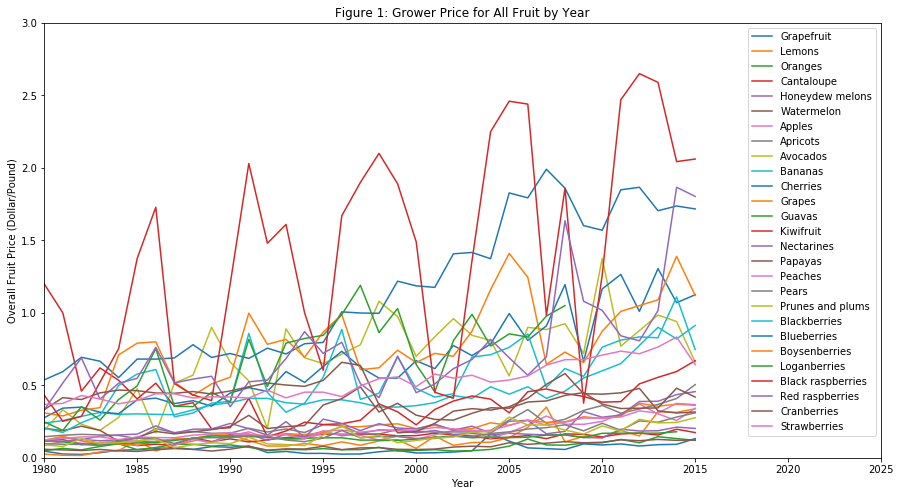

In [77]:
# sort data before plotting
final_data.sort_values(['Category', 'Fruit', 'Year'], ascending=[True, True, True])

plt.figure(figsize=(15,8),facecolor='w') 
ax = plt.subplot(111)
for temp in (final_data.Fruit.unique()):
    dat = final_data[final_data.Fruit==temp]
    year =  dat.Year
    plt.plot(year, dat.All, label = dat.Fruit.values[0])

plt.xlabel("Year")
plt.ylabel("Overall Fruit Price (Dollar/Pound)")
ax.axis([1980, 2025, 0, 3])
plt.legend()
plt.title('Figure 1: Grower Price for All Fruit by Year')
plt.show()


It's hard to see anything from the plot above, but we can see the obvious seasonality trend from black raspberries still. 

#### Compare average prices for each category.  

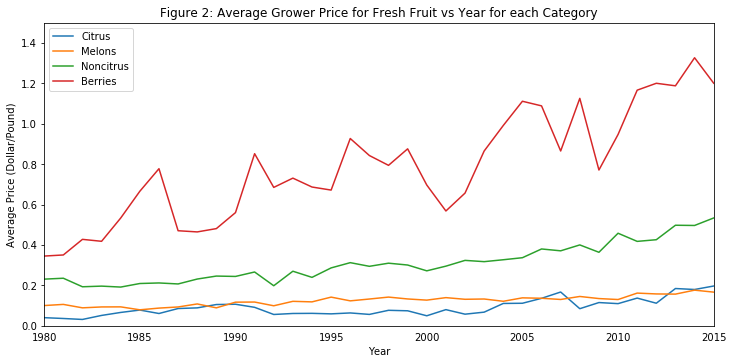

In [101]:
# get dataset of averages by category
avgByCategory = final_data.groupby(['Category', 'Year'])['All'].mean()
avgByCategory= avgByCategory.reset_index()
avgByCategory

# plot processed fruit vs year
fig, ax = plt.subplots(figsize=(10,5),facecolor='w')
for temp in (final_data.Category.unique()):
    dat = avgByCategory[avgByCategory.Category==temp]
    year =  dat.Year
    plt.plot(year, dat.All, label = dat.Category.values[0])
    
plt.tick_params(bottom = 'off')      
plt.xlabel("Year")
plt.ylabel("Average Price (Dollar/Pound)")
plt.title('Figure 2: Average Grower Price for All Fruit vs Year for each Category')
plt.tight_layout(pad=0.5, h_pad=1.5)
plt.legend(loc= "upper left")
ax.axis([1980, 2015, 0, 1.5])
plt.show()


Other than berries with a greater magnitude of fluctuation, the overall price for noncitrus, citrus, and melons are stable. The slope for nonctrius fruit is positive, but the slope for citrus and melons are closer to 0. Overall, the average grower price for melons and citrus fruit don't change much in the 35 years. 

#### Make a figure with individual and average fresh fruit prices for each category

In [179]:
k = cm.rainbow(np.linspace(0, 7, 7))
print(k)

[[  5.00000000e-01   0.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.22464680e-16   6.12323400e-17   1.00000000e+00]
 [  1.00000000e+00   1.22464680e-16   6.12323400e-17   1.00000000e+00]
 [  1.00000000e+00   1.22464680e-16   6.12323400e-17   1.00000000e+00]
 [  1.00000000e+00   1.22464680e-16   6.12323400e-17   1.00000000e+00]
 [  1.00000000e+00   1.22464680e-16   6.12323400e-17   1.00000000e+00]
 [  1.00000000e+00   1.22464680e-16   6.12323400e-17   1.00000000e+00]]


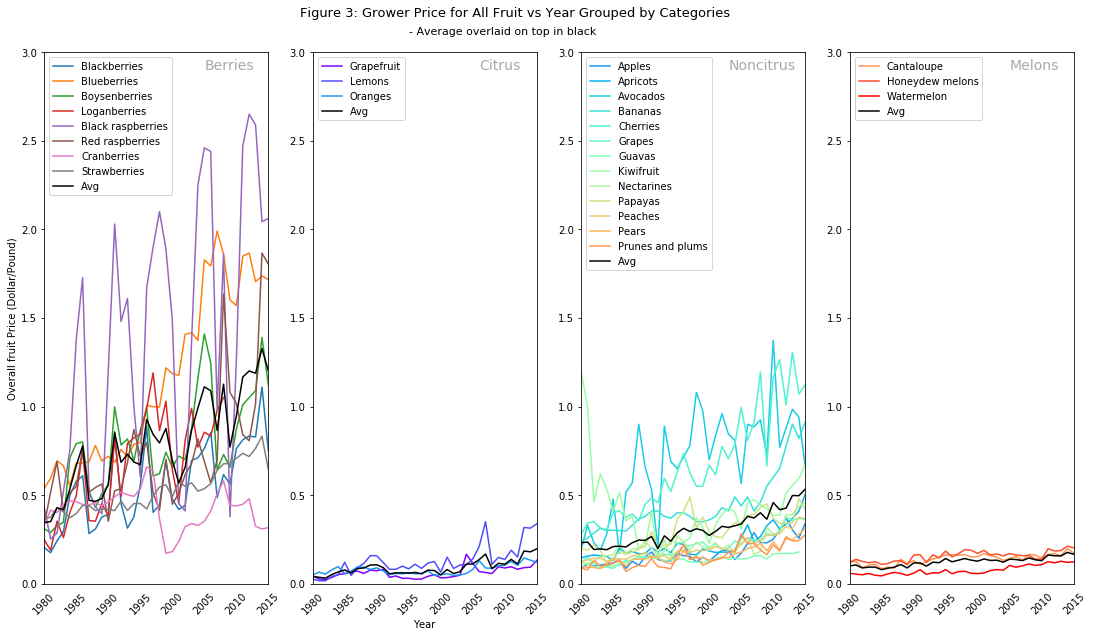

In [197]:
# Plot all price grouped by categories with average overlaid on top

# plot processed fruit vs year
fig, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(15,8))
#fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)

dat = final_data[final_data.Category=='Berries']
for f in dat['Fruit'].unique(): 
    dat2 = dat[dat.Fruit == f]
    year = dat2.Year
    ax1.plot(year, dat2.All, label = f)
    ax1.tick_params(bottom = 'off')
k = avgByCategory[avgByCategory.Category == 'Berries']
ax1.plot(k.Year, k.All, label = 'Avg', color = 'black')
    
dat = final_data[final_data.Category=='Citrus']
colors = cm.rainbow(np.linspace(0, 0.2, len(dat['Fruit'].unique())))
for f, c in zip(dat['Fruit'].unique(), colors): 
    dat2 = dat[dat.Fruit == f]
    year = dat2.Year    
    ax2.plot(year, dat2.All, label = f, color = c)
    ax2.tick_params(bottom = 'off')
k = avgByCategory[avgByCategory.Category == 'Citrus']
ax2.plot(k.Year, k.All, label = 'Avg', color = 'black')
    
dat = final_data[final_data.Category=='Noncitrus']
colors = cm.rainbow(np.linspace(0.2, 0.8, len(dat['Fruit'].unique())))
for f, c in zip(dat['Fruit'].unique(), colors): 
    dat2 = dat[dat.Fruit == f]
    year = dat2.Year
    ax3.plot(year, dat2.All, label = f, color = c)
    ax3.tick_params(bottom = 'off')
k = avgByCategory[avgByCategory.Category == 'Noncitrus']
ax3.plot(k.Year, k.All, label = 'Avg', color = 'black')

dat = final_data[final_data.Category=='Melons']
colors = cm.rainbow(np.linspace(0.8, 1, len(dat['Fruit'].unique())))
for f, c in zip(dat['Fruit'].unique(), colors): 
    dat2 = dat[dat.Fruit == f]
    year = dat2.Year
    ax4.plot(year, dat2.All, label = f, color = c)
    ax4.tick_params(bottom = 'off')
k = avgByCategory[avgByCategory.Category == 'Melons']
ax4.plot(k.Year, k.All, label = 'Avg', color = 'black')

ax1.set_ylabel("Overall fruit Price (Dollar/Pound)")
ax2.set_xlabel("Year")
#plt.ylabel("Fruit Price (Dollar/Pound)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

# create title
ax1.text(2020, 3.2, 'Figure 3: Grower Price for All Fruit vs Year Grouped by Categories', fontsize = 13)
ax2.text(1995, 3.1, '- Average overlaid on top in black', fontsize = 11)

plt.tight_layout(pad=0.5, h_pad=1.5)

# set axis range
ax1.axis([1980, 2015, 0, 3])
ax2.axis([1980, 2015, 0, 3])
ax3.axis([1980, 2015, 0, 3])
ax4.axis([1980, 2015, 0, 3])

# label the categories
ax1.text(2005, 2.9, 'Berries', size= 14, color = 'darkgray')
ax2.text(2006, 2.9, 'Citrus', size= 14, color = 'darkgray')
ax3.text(2003, 2.9, 'Noncitrus', size= 14, color = 'darkgray')
ax4.text(2005, 2.9, 'Melons', size= 14, color = 'darkgray')

# rotate x labels by 45 degree
for i in [ax1, ax2, ax3, ax4]: 
    for tick in i.get_xticklabels():
        tick.set_rotation(45)
plt.show()


Figure 3 is very similar to Figure 4 of Part II, but with greater fluctuation. The averages have smaller slopes as well. Again, the fruit category with the highest degree of fluctuation is berries, then noncitrus fruits, then citrus fruits, then melons. Again, this makes sense as the grower price reflect how much care the growers need to put in for the fruits. Melons have an even harder shell protecting the meat of the fruit, so the price is even lower than that of citrus fruits. 

The grower price on melons are suppose to be lower than that on citrus, but they're roughly equal due to the scale of Figure 3. Therefore, we will examine and compare just these two fruit categories in Figure 4. 

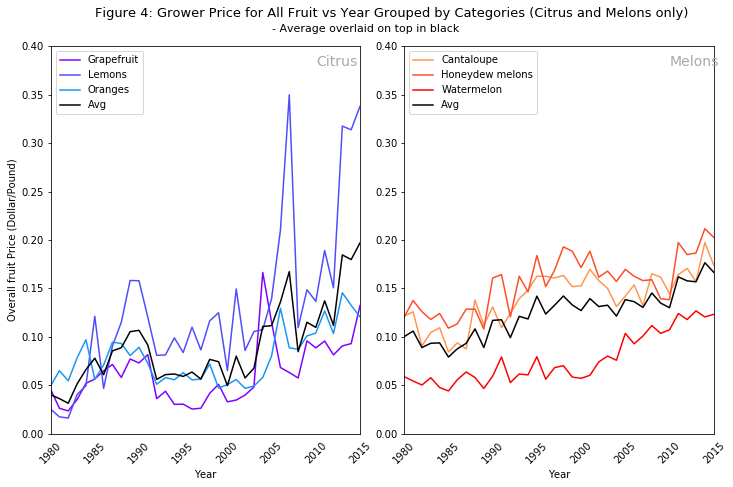

In [205]:
# Plot all price grouped by categories with average overlaid on top

# plot processed fruit vs year
fig, ((ax1), (ax2)) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)


dat = final_data[final_data.Category=='Citrus']
colors = cm.rainbow(np.linspace(0, 0.2, len(dat['Fruit'].unique())))
for f, c in zip(dat['Fruit'].unique(), colors): 
    dat2 = dat[dat.Fruit == f]
    year = dat2.Year    
    ax1.plot(year, dat2.All, label = f, color = c)
    ax1.tick_params(bottom = 'off')
k = avgByCategory[avgByCategory.Category == 'Citrus']
ax1.plot(k.Year, k.All, label = 'Avg', color = 'black')

dat = final_data[final_data.Category=='Melons']
colors = cm.rainbow(np.linspace(0.8, 1, len(dat['Fruit'].unique())))
for f, c in zip(dat['Fruit'].unique(), colors): 
    dat2 = dat[dat.Fruit == f]
    year = dat2.Year
    ax2.plot(year, dat2.All, label = f, color = c)
    ax2.tick_params(bottom = 'off')
k = avgByCategory[avgByCategory.Category == 'Melons']
ax2.plot(k.Year, k.All, label = 'Avg', color = 'black')

ax1.set_ylabel("Overall fruit Price (Dollar/Pound)")
ax1.set_xlabel("Year")
ax2.set_xlabel("Year")
#plt.ylabel("Fruit Price (Dollar/Pound)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

# create title
ax1.text(1985, 0.43, 'Figure 4: Grower Price for All Fruit vs Year Grouped by Categories (Citrus and Melons only)', fontsize = 13)
ax1.text(2005, 0.415, '- Average overlaid on top in black', fontsize = 11)

plt.tight_layout(pad=0.5, h_pad=1.5)

# set axis range
ax1.axis([1980, 2015, 0, 0.4])
ax2.axis([1980, 2015, 0, 0.4])

# label the categories
ax1.text(2010, 0.38, 'Citrus', size= 14, color = 'darkgray')
ax2.text(2010, 0.38, 'Melons', size= 14, color = 'darkgray')

# rotate x labels by 45 degree
for i in [ax1, ax2, ax3, ax4]: 
    for tick in i.get_xticklabels():
        tick.set_rotation(45)
plt.show()


Interestingly, the melon prices aren't much lower than that of citrus prices. The average overall grower price for melons seems to be higher than that of citrus fruits. As expected, watermelon has the lowest average overall price in these 35 years, even though grapefruit have a low price as well. 

### Conclusion

On top of what we've learned from part II, we can also see that: 

1. Berries exhibit a much greater fluctuation and steeper slope than the other fruit categories (Figure 2). 
2. In terms of average prices, berries > noncitrus > citrus/melons (Figure 2). 
3. In terms of individual prices, berries > noncitrus > citrus fruits/melons roughly (Figure 3). 
4. Watermelons tend to have the lowest average grower price for all fruits (Figure 4). 
5. In terms of average prices, not all melons have lower prices than that of citrus fruits (Figure 4). 

Supposely, the melons should have a lower grower price than citrus. However, we discovered that it's not necessarily true for all fruits in those categories. For example, other than lemon, the other citrus fruits tend to have a lower price than that of melons except watermelons. 